In a [previous post](), I covered arguably one of the most straight-forward clustering algorithms: hierarchical clustering. Remember that any clustering method requires a **distance metric** to quantify how "far apart" two points are placed in some N-dimensional space. While typically Euclidean, there's loads of ways in doing this.

Generally, hierarchical clustering is a very good way of clustering your data, though it suffers from a couple of limitations:
* Users have to define the number of clusters
* The linkage criterion (UPGMA, Ward...) can have a huge effect on the cluster shapes

Other clustering methods like K-means clustering also depend on the number of clusters to be determined beforehand, and it can be prone to hitting local minima. 

In theory, no clustering method is perfect, as it is very much dependent on the shape of your data and use case. This diagram from Scikit-learn shows us exactly that:

![Clustering](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

However, if I had to pick one clustering algorithm for any dataset, it would have to be DBSCAN (Density-based spatial clustering of applications with noise). Cheeky plug: I've written a paper on [using it for clustering protein structures](https://www.frontiersin.org/articles/10.3389/fimmu.2019.02454/abstract). Essentially, DBSCAN wins the "clustering trophy" for three reasons:
* It's very intuitive to understand
* It's very scalable
* It requires a distance parameter rather than the number of clusters


If you have...
* **30 seconds** DBSCAN  essentially requires a user to determine a distance parameter, $\epsilon$.
$$P_i = \begin{cases} \text{Core} & \text{if}\ (\sum_{j=1, j\neq i}^{n} \mathbb{1}(d_{P_i, P_j} \leq \epsilon)) \geq m \\
\text{Reachable} & \text{if}\ 0 < (\sum_{j=1, j\neq i}^{n} \mathbb{1}(d_{P_i, P_j} \leq \epsilon)) < m \\
\text{Outlier} & \text{Otherwise.}
\end{cases}
$$ The combinaiton of core and reachable points form a cluster, while outliers are... outliers.
* **7 minutes** Read below.

To run DBSCAN, we first define some distance threshold, $\epsilon$, and the minimum number of points, $m$, we need to form a cluster. Notice the slight difference to how we parameterise hierarchical clustering methods; instead of having a declaration such as
> I expect my dataset to have 10 clusters from 1000 points.

This is more analogous to saying
> I expect my dataset of 1000 points to form bunches that are, at most, $\epsilon$ apart.

If you like LateX/equations, the _i_th point of a dataset, $P_i$, can be designated one of three things:
$$P_i = \begin{cases} \text{Core} & \text{if}\ (\sum_{j=1}^{n} \mathbb{1}(d_{P_i, P_j} \leq \epsilon)) \geq m \\
\text{Reachable} & \text{if}\ 0 < (\sum_{j=1}^{n} \mathbb{1}(d_{P_i, P_j} \leq \epsilon)) < m \\
\text{Outlier} & \text{Otherwise.}
\end{cases}
$$ 

One of the most helpful ways of understanding DBSCAN is using this diagram from Wikipedia:

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/800px-DBSCAN-Illustration.svg.png)

Suppose we had a minimum of 4 ($m=4$). Then, 
* The red points are _core points_. For every red point, we see that, including itself, there are at least 4 red points within $\epsilon$ (illustrated by the double-sided arrow). However, 
* The two yellow points are only "reachable" as there's less than $m$ points within $\epsilon$ (including itself). Hence the yellow points are not core points. 
* And of course, the blue point is just a chillin' outlier.

The combination of red and yellow points form a cluster! We repeat this process for every point in our dataset, and we're done. Now let's run some code.

## Data Acquisition and Cleaning

In [1]:
# Import stuff
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np

For this blog post, I am going to ingest a huge dataset of gene expression data from [GTEx](https://gtexportal.org/home/datasets). The GTEx portal is a really [interesting resource](https://www.nature.com/articles/nature24277), which describes how genes are differentially expressed in specific tissues. This can be measured by a quantity known as TPM (Transcripts per million). The data itself was acquired by RNA sequencing from post-mortem samples. There's data, and metadata we could use, but for simplicity let's stick to using only the TPM data, and ignore the metadata completely (though it could be useful for informing our clustering strategy).

Since the file from GTEx is pretty big, we're going to `stream` it and use some clever tricks! 

In [2]:
import gzip
import urllib
import io

# Let's stream the data
URL = "https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz"
urlHandle = urllib.request.urlopen(URL)

# Create a Gzipped File handle - this allows line-by-line iteration
fh = gzip.GzipFile(fileobj=urlHandle)

Having dealt with GCT files before, with a [weird format](https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats), we need to skip the first line, but the second line onward has some useful information.

In [3]:
fh.readline() # skip first line
dimensions = fh.readline().split()

In [4]:
[int(x) for x in dimensions]

[56200, 17382]

The GCT file format is interesting because it tells us the dimensions of the file; there are 56200 genes and 17382 samples. That's a lot of genes to work with; not to mention quite a few samples, too. This of course means there are 56200 rows and 17382 columns, which could be pretty cumbersome for a laptop to handle. Not to mention downloading the entire thing all at once _before_ we do anything else. 

To trim it down a bit, let's see what these samples are, first:

In [5]:
DECODE_CODEC = 'utf-8'

def stream_request(url):
    """
    Open a connection to some url, then stream data from it
    This has the advantage of:
    A. We don't have to wait for the entire file to download to do operations
    B. We can perform some operations on-the-fly
    """
    fh = urllib.request.urlopen(url)
    buffer = io.StringIO()
    
    for line in fh:
        decoded = line.decode(DECODE_CODEC)
        buffer.write(decoded)
    
    # Reset the StringIO buffer to byte position 0
    buffer.seek(0)
    return buffer
    
def stream_request_to_pandas(url: str, sep: str = '\t') -> pd.DataFrame:
    streamed_buffer = stream_request(url)
    return pd.read_csv(streamed_buffer, sep = sep)

In [6]:
sampleUrl = "https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"
sample_df = stream_request_to_pandas(sampleUrl)

In [7]:
# Just get a random 4 rows and the first 10 columns
sample_df.iloc[np.random.randint(0, 1000, 4)][sample_df.columns[:10]]

,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX
34,GTEX-111CU-1426-SM-5GZYP,1.0,B1,"6 pieces, predominantly mucosa and submucosa w...",7.8,Colon,Colon - Transverse,0001157,100.0,609.0
390,GTEX-11DXZ-1926-SM-5GZZL,0.0,B1,"4 pieces, predominantly fat with ~10-20% fibro...",7.7,Breast,Breast - Mammary Tissue,0008367,318.0,883.0
562,GTEX-11EQ9-1126-SM-5987I,1.0,B1,"2 pieces, !0% fibrovascular tissue, delineated",7.8,Adipose Tissue,Adipose - Visceral (Omentum),0010414,105.0,594.0
506,GTEX-11EMC-0008-SM-5Q5DR,NaN,B1,NaN,10.0,Skin,Cells - Cultured fibroblasts,EFO_0002009,809.0,NaN


For sake of argument, I'm only going to get samples where the source was Blood, Blood Vessel, and Hear (`SMTS == Blood Vessel|Blood|Heart`).

In [8]:
tissues_of_interest = sample_df[sample_df['SMTS'].isin(['Blood', 'Blood Vessel', 'Heart'])]
relevant_samples = tissues_of_interest['SAMPID'].values

In [9]:
# This will be useful later, trust me!
# This is a dictionary of sample ID -> tissue location
sample_id_to_smts = dict(tissues_of_interest[['SAMPID','SMTS']].values)
sample_id_to_smtsd = dict(tissues_of_interest[['SAMPID','SMTSD']].values)

Furthermore, I am only going to read the rows of data that have protein-coding genes.

In [10]:
geneUrl = "https://www.genenames.org/cgi-bin/download/custom?col=gd_app_sym&col=gd_pub_ensembl_id&status=Approved&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&where=(gd_pub_chrom_map%20not%20like%20%27%25patch%25%27%20and%20gd_pub_chrom_map%20not%20like%20%27%25alternate%20reference%20locus%25%27)%0Aand%20gd_locus_type%20=%20%27gene%20with%20protein%20product%27&submit=submit"
gene_df = stream_request_to_pandas(geneUrl)

In [11]:
# Let's get the Ensembl Gene IDs of things that are protein-coding
gene_ensembl = gene_df[~pd.isnull(gene_df['Ensembl gene ID'])]['Ensembl gene ID'].values

OK. Now that we have:
* Protein coding genes, and
* Sample IDs that mark whether samples are from blood, heart, or blood vessel...

We can extract what we want!

In [12]:
# From that big GTEx file, let's get the column names
header = fh.readline().decode("utf-8").split('\t')

# Find out what columns (in terms of indices) these samples correspond to.
# We want 0 and 1 by default because they are the Ensembl gene ID and Gene name
header_indices = [0,1] + [ ix for ix, val in enumerate(header) if val in relevant_samples ]

# Use numpy arrays because then we can use multiple integers for indexing!
dataframe_columns = np.array(header)[header_indices]

In [13]:
from tqdm.notebook import tqdm # nice little progress bar

data = []
ENSEMBL_LENGTH = 15 # obtained from gene_ensembl

for line in tqdm(fh):    
    strline = line.decode('utf-8')
    if strline[:ENSEMBL_LENGTH] in gene_ensembl:
        tokens = np.array(strline.split('\t'))
        data.append(tokens[header_indices])

In [14]:
# Create a pandas data-frame with our data
expression = pd.DataFrame(data, columns = dataframe_columns)

In [15]:
expression.iloc[np.random.randint(0, 1000, 4)]

,Name,Description,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-111FC-0426-SM-5N9CV,GTEX-111FC-0626-SM-5N9CU,GTEX-111FC-0826-SM-5GZWO,GTEX-111VG-0326-SM-5GZX7,GTEX-111YS-0006-SM-5NQBE,...,GTEX-ZYW4-0926-SM-59HJS,GTEX-ZYW4-1226-SM-5E45B,GTEX-ZYY3-1226-SM-5EQKM,GTEX-ZZ64-1326-SM-5E444,GTEX-ZZPT-0926-SM-5GICZ,GTEX-ZZPU-0226-SM-5N9BV,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1026-SM-5E457,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-2426-SM-5E44I
89,ENSG00000171680.21,PLEKHG5,5.088,17.82,7.634,7.388,13.87,10.71,7.467,0.1476,...,5.941,8.948,9.802,2.254,4.893,26.05,9.067,15.91,5.677,2.25
49,ENSG00000187730.8,GABRD,0.8109,3.613,7.357,1.212,0.4054,0.2379,0.5227,0,...,0.3053,0.3506,0.6624,0.08878,0.2648,0.569,0.2708,2.359,0.227,0
375,ENSG00000009780.15,FAM76A,17.9,15.63,3.554,12.57,9.711,5.01,4.13,1.647,...,3.287,10.82,8.789,7.545,4.966,10.32,4.235,6.512,5.418,10.1
486,ENSG00000116898.11,MRPS15,22.21,35.78,19.51,34.85,43.69,38.74,26.54,14.47,...,17.62,31.83,28.45,41.58,28.96,34.51,36.19,31.35,33.63,34.51


In [16]:
expression.shape

(18619, 3127)

# Understanding the Data

In [17]:
# Let's get the TPM values of the matrix
vals = expression[expression.columns[2:]].astype(float).values.T

Let's consider what we have here. We got the TPM values from the dataframe, converted it to `float`, then took the _transpose_ of this matrix. This means we now have _samples_ per row and _genes_ per column.

Every clustering algorithm needs to have some type of distance metric to compute how far apart two objects are. If we had had the _genes_ in rows, this would have meant we're calculating _how far apart two genes are_ (based on TPM), though the tranpose shows _how far apart two samples are_.

This then means that we're going to cluster on the basis of the distances between samples, rather than genes. This was a deliberate choice to see if DBSCAN can roughly identify three clusters that correspond to - you guessed it, **Blood, Blood Vessel, and Heart**. 
> Just as an FYI, of course you can just cluster on the genes, though interpretation could be tricky. In fact, one could even do bi-clustering for something like this, but I digress...

Another nice aspect of this is computational scalability. Previously we had a $n\times k$ matrix of $n$ genes and $k$ samples ($18619 \times 3127$). The distance matrix of genes would be $n \times n$, while a distance matrix of samples is just $k \times k$.

Let's see what the range of TPM values can look like - this can help us understand what the distances would be like.

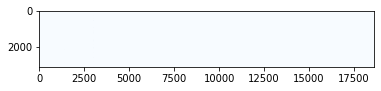

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# Let's plot a heatmap first, as it's a matrix
plt.imshow(vals, interpolation='nearest', cmap = 'Blues')

Hmm... that doesn't look quite right. How about we flatten out those values and create a histogram?

Min: 0.0, Max: 747400.0, Mean: 50.455648440229176, Median: 3.181


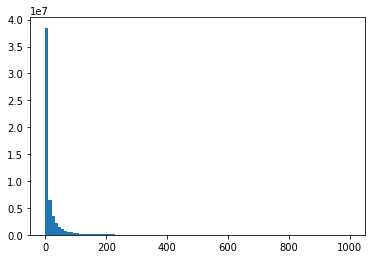

In [20]:
# Flatten to a 1-dimensional vector.
valarray = vals.flatten()

min_tpm = np.min(valarray)
max_tpm = np.max(valarray)
mean_tpm = np.mean(valarray)
median_tpm = np.median(valarray)

# Draw the histogram
o = plt.hist(valarray, bins = np.arange(0, 1001, 10))

print("Min: {}, Max: {}, Mean: {}, Median: {}".format(min_tpm, max_tpm, mean_tpm, median_tpm))

OK, so the distribution is very skewed, with some values having very, very high values, and with nearly the entire dataset falling within 100TPM. One way to go around this is to use log transformation using a pseudocount of 1. $$\log_\text{TPM} = log(\text{TPM}+1)$$.

By giving everything a pseudo-count of 1, this means that genes with 0 TPM in some samples will be transformed to 0, while for other genes, this shouldn't have a huge effect. 

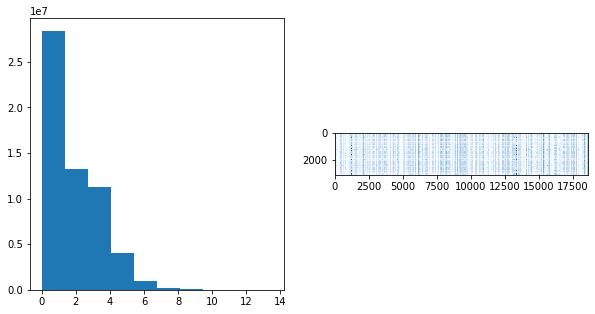

In [21]:
logTpm = np.log(vals+1)

logTpmArray = logTpm.flatten()

fig, ax = plt.subplots(1,2)
ax[0].hist(logTpmArray)
ax[1].imshow(logTpm, interpolation='nearest', cmap = 'Blues')

fig.set_size_inches((10,5))

Now that looks a lot better. We will calculate the pairwise distances based on this log TPM value.

In [23]:
# pairwise distances - use default of Euclidean though there are various ways of doing this
# This will take a while since there's ~3000 pairwise distances to compute.
from scipy.spatial.distance import pdist
dmat = pdist(logTpm)

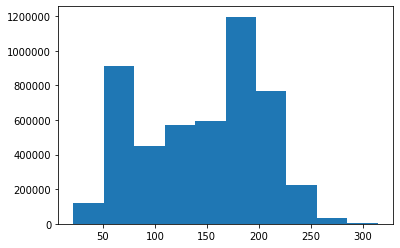

In [24]:
# Let's look at the distribution of distances
o = plt.hist(dmat)

# MDS + DBSCAN

For visualisation of the clusters, we're going to create a multi-dimensional scaling plot. In a nutshell, when given some distances between objects, MDS tries to reconstruct where various points sit with respect to each other. 

The analogy is something like, if you know the pairwise distances between New York, London, Tokyo, Sydney, and Dubai, MDS tries to figure out where those cities would sit (in a coordinate sense) from using just the distances alone.

In [25]:
from scipy.spatial.distance import squareform

# Convert distance matrix from pdist into a square matrix
sqmat = squareform(dmat)

In [26]:
# Import some stuff
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS

# Initialise an MDS object, this allows us to visualise points in space
mds = MDS(dissimilarity='precomputed')

In [27]:
# This step can take a while
np.random.seed(0)
coords = mds.fit_transform(sqmat)

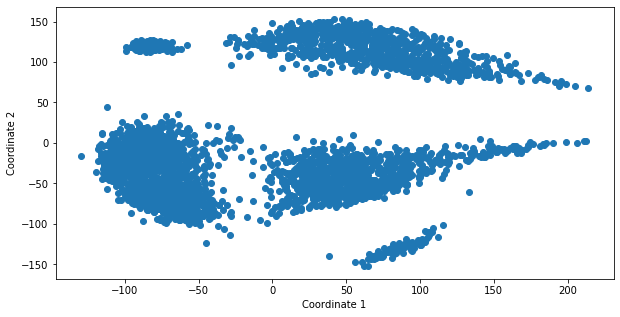

In [46]:
# Let's see what the MDS generates for the samples
plt.scatter(coords[:,0], coords[:,1])

plt.gcf().set_size_inches((10,5))
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.savefig("mds.png", dpi = 600)

Now that we know where the samples sit with respect to each other, let's see what the DBSCAN algorithm generates. We mentioned earlier that the DBSCAN algorithm depends on some distance parameter, $\epsilon$, to determine how objects are clustered together.
* For large values of $\epsilon$, objects will all be consumed into one cluster
* For small values of $\epsilon$, objects will break down into individual singletons

So then, how do we choose a good value of $\epsilon$? This is usually achievable by an algorithm called OPTICS, but looking at our distance histogram from earlier, we can see that 75 could be a reasonable choice.

In [33]:
from sklearn.cluster import DBSCAN

THRESHOLD = 75

dbscan = DBSCAN(metric='precomputed', eps = THRESHOLD) # we calculated the distance already
dbscan.fit(sqmat)

print(set(dbscan.labels_))

{0, 1, 2, -1}


This is an interesting result; there are some outliers (label -1), but it found three distinct clusters even if I did not specify that there would be three clusters! How neat. Just for sake of argument, we can see how this result changes for very large or very small values of epsilon:

In [34]:
dbscan_large = DBSCAN(metric='precomputed', eps = 250) # we calculated the distance already
dbscan_large.fit(sqmat)

dbscan_small = DBSCAN(metric='precomputed', eps = 1) # we calculated the distance already
dbscan_small.fit(sqmat)

print("These are the clusters for large EPS: {}".format(set(dbscan_large.labels_)))

print("These are the clusters for small EPS: {}".format(set(dbscan_small.labels_)))

These are the clusters for large EPS: {0}
These are the clusters for small EPS: {-1}


So it seems like the optimal epsilon value sits somewhere between 1 and 100. Let's visualise using our original results.

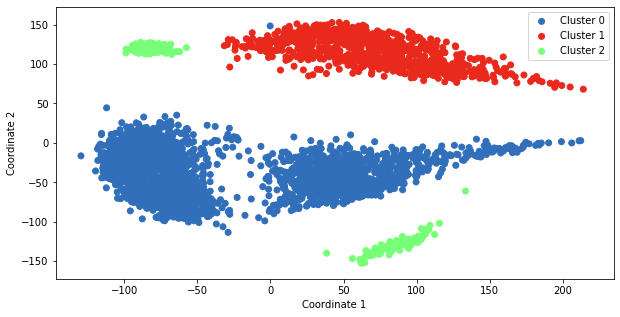

In [44]:
# Colour points based on cluster membership
cols = {0: '#316fba', 1: '#e8291c', 2: '#77ff77', -1:'black'}
colours = np.array([ cols[c] for c in dbscan.labels_ ])

# Now let's see what the clusters look like
zero_idx = np.argwhere(dbscan.labels_==0).flatten()
one_idx = np.argwhere(dbscan.labels_==1).flatten()
two_idx = np.argwhere(dbscan.labels_==2).flatten()

plt.scatter(coords[:,0][zero_idx], coords[:,1][zero_idx], c = colours[zero_idx], label = "Cluster 0")
plt.scatter(coords[:,0][one_idx], coords[:,1][one_idx], c = colours[one_idx], label = "Cluster 1")
plt.scatter(coords[:,0][two_idx], coords[:,1][two_idx], c = colours[two_idx], label = "Cluster 2")

plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")

plt.legend(loc = 'upper right')

plt.gcf().set_size_inches((10,5))
plt.savefig("gtex_clusters.png", dpi = 600)

That's beautiful isn't it? Notice how the green dots are situated in two distinct areas of this MDS plot. This is not a surprising behaviour because we're plotting the samples in a two-dimensional MDS plot, which is a reconstruction from the distance matrix we gave. In fact, in a higher-dimensional space, it's likely that these green dots are indeed close, but beyond three dimensions it's slightly hard to visualise dots.

Anyway, let's see if our clusters vaguely capture the cellular locations.

In [36]:
sample_ids_used = expression.columns[2:]
tissues_represented = {0: set(), 1: set(), 2: set(), -1: set()}

for i, label in enumerate(dbscan.labels_):        
    sample_id = sample_ids_used[i]
    tissue = sample_id_to_smts[sample_id]
    
    tissues_represented[label].add(tissue)

In [37]:
tissues_represented

{0: {'Blood Vessel', 'Heart'},
 1: {'Blood'},
 2: {'Blood'},
 -1: {'Blood', 'Blood Vessel'}}

This is a very neat result. It seems that samples from the Blood Vessel and Heart have similar tissue expression patterns, though Blood can be broken down to two separate clusters. Let's look at the finer location of the tissue (based on the `SMTSD` column from GTEx rather than `SMTS`)...

In [38]:
finer_represented = {0: set(), 1: set(), 2: set(), -1: set()}

for i, label in enumerate(dbscan.labels_):        
    sample_id = sample_ids_used[i]
    smtsd = sample_id_to_smtsd[sample_id]
    
    finer_represented[label].add(smtsd)

In [39]:
finer_represented

{0: {'Artery - Aorta',
  'Artery - Coronary',
  'Artery - Tibial',
  'Heart - Atrial Appendage',
  'Heart - Left Ventricle'},
 1: {'Whole Blood'},
 2: {'Cells - EBV-transformed lymphocytes'},
 -1: {'Artery - Tibial', 'Whole Blood'}}

Very interesting indeed. So the arteries are close to the heart (aorta, coronary artery), and we see these samples clustering together. On the other hand, even though samples are designated as belonging to "blood", we see that there are two sub-samples of whole blood or from EBV-transformed lymphocytes. This is very neat.

Again, this shows how, even when I haven't specified the number of clusters, but merely a distance, the algorithm detects three clusters, which broadly correspond to the three regions that we had specified earlier.

Hopefully this shows you all how cool DBSCAN can be, and coupled with MDS, gives us an intuition for where samples can lie in some 2-dimensional manifold.